## Citation/Disclaimer
Code was built off of Peizhe Huang's project found here
https://github.com/huangpz-a11y/P2_Monetary_Tightening/tree/main

# Load Data

First, we begin to load the data. We use a mixture of sources. We web-scraped to get the S&P Treasury Index data and used yfinance for the iShare MBS ETF data.

In [1]:
import pandas as pd
import load_WRDS
import load_assets
import config
import Clean_data

import numpy as np
from pathlib import Path

import os
import time
import pandas as pd


DATA_DIR = config.DATA_DIR
OUTPUT_DIR = config.OUTPUT_DIR

# Load the data from WRDS
rcfd_series_1 = load_WRDS.load_RCFD_series_1(data_dir=DATA_DIR)
rcon_series_1 = load_WRDS.load_RCON_series_1(data_dir=DATA_DIR)
rcfd_series_2 = load_WRDS.load_RCFD_series_2(data_dir=DATA_DIR)
rcon_series_2 = load_WRDS.load_RCON_series_2(data_dir=DATA_DIR)


# Reading CSV files and handling the 'date' column
df_iShare_MBS_ETF = pd.read_csv('MBS.csv')
df_iShare_MBS_ETF['Date'] = pd.to_datetime(df_iShare_MBS_ETF['Date'])  # Handle 'Date' column
df_iShare_MBS_ETF_1 = df_iShare_MBS_ETF.copy()
df_iShare_MBS_ETF_1 = df_iShare_MBS_ETF_1.set_index("Date").asfreq("D").ffill()  # Set index and forward fill
df_iShare_MBS_ETF_1 = df_iShare_MBS_ETF_1.reset_index()  # Reset index if needed

# Reading 'Tres.csv' for treasury prices
treasury_prices = pd.read_csv('Tres.csv')
treasury_prices['date'] = pd.to_datetime(treasury_prices['date'])  # Handle 'date' column
treasury_prices_1 = treasury_prices.copy()
treasury_prices_1 = treasury_prices_1.set_index("date").asfreq("D").ffill()  # Set index and forward fill
treasury_prices_1 = treasury_prices_1.reset_index()  # Reset index if needed
treasury_prices_1_all_dates = treasury_prices_1.copy()  # Create a copy for all dates

# Reading 'TresIndex.csv' for treasury bond index
df_SP_Treasury_bond_index = pd.read_csv('TresIndex.csv')
df_SP_Treasury_bond_index['date'] = pd.to_datetime(df_SP_Treasury_bond_index['date'])  # Handle 'date' column
df_SP_Treasury_bond_index_1 = df_SP_Treasury_bond_index.copy()
df_SP_Treasury_bond_index_1 = df_SP_Treasury_bond_index_1.set_index("date").asfreq("D").ffill()  # Set index and forward fill
df_SP_Treasury_bond_index_1 = df_SP_Treasury_bond_index_1.reset_index()  # Reset index if needed


# Analysis

For the MBS data, the correlation matrix shows that MBS price metrics (Adj Close, High, Low, and Open) are perfectly correlated (1.0), indicating they move in lockstep with minimal intraday volatility. Trading volume has a weak negative correlation (-0.22 to -0.23) with prices, suggesting slight selling pressure when volume rises, but not enough to be a strong predictor of price movements. Overall, MBS prices appear stable, with volume having limited impact, meaning traders may need to rely on other indicators like interest rates or macroeconomic trends for deeper insights.

MBS trading volume does not appear to be a strong predictor of price movements. The price remains relatively stable, and spikes in trading volume might be driven by macro events or institutional rebalancing rather than speculative activity.

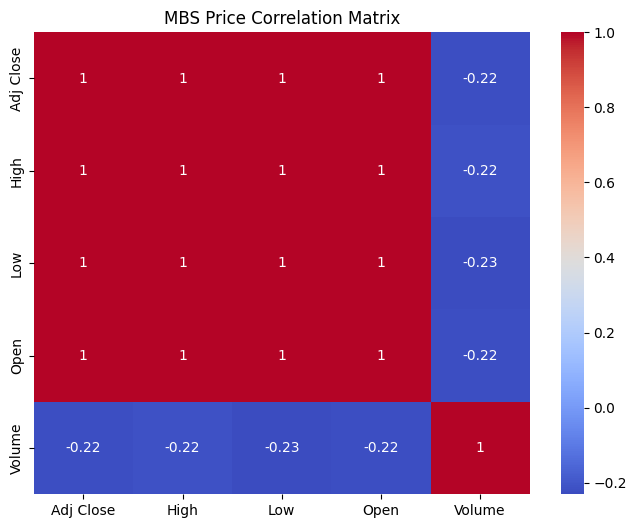

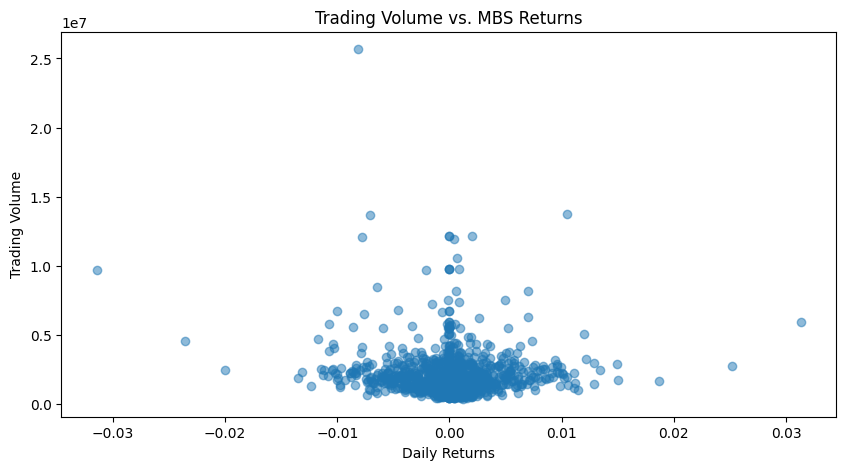

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

df_mbs = df_iShare_MBS_ETF_1.copy()

df_mbs["Returns"] = df_mbs["Adj Close"].pct_change()

# Rolling Mean & Volatility (20-day window)
df_mbs["Rolling Mean"] = df_mbs["Adj Close"].rolling(window=20).mean()
df_mbs["Volatility"] = df_mbs["Returns"].rolling(window=20).std()

# Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df_mbs[["Adj Close", "High", "Low", "Open", "Volume"]].corr(), annot=True, cmap="coolwarm")
plt.title("MBS Price Correlation Matrix")
plt.show()

# Trading Volume vs. Price Change
plt.figure(figsize=(10, 5))
plt.scatter(df_mbs["Returns"], df_mbs["Volume"], alpha=0.5)
plt.xlabel("Daily Returns")
plt.ylabel("Trading Volume")
plt.title("Trading Volume vs. MBS Returns")
plt.show()

##### Treasury Heatmap

The heatmap below confirms that longer-term Treasury bonds move together, while short-term bonds behave differently, likely due to differing sensitivity to rate changes. S&P bond indices also align closely with medium and long-term bond ETFs. This suggests that for portfolio diversification, mixing short-term and long-term bonds can provide better balance against interest rate shifts.

The graph tracks the yield spread between short-term and long-term bonds over time, reflecting shifts in economic conditions. Initially, the spread rises, indicating that long-term bond yields were increasing faster than short-term yields, often a sign of economic expansion and inflation expectations. The spread then peaks and begins to decline, suggesting a shift where long-term yields fall relative to short-term yields, possibly due to changing monetary policy or economic uncertainty. Toward the end, the spread approaches zero, indicating that short-term and long-term bonds are yielding nearly the same. If this trend continues into negative territory, it could signal an inverted yield curve, a historically reliable indicator of an impending recession.

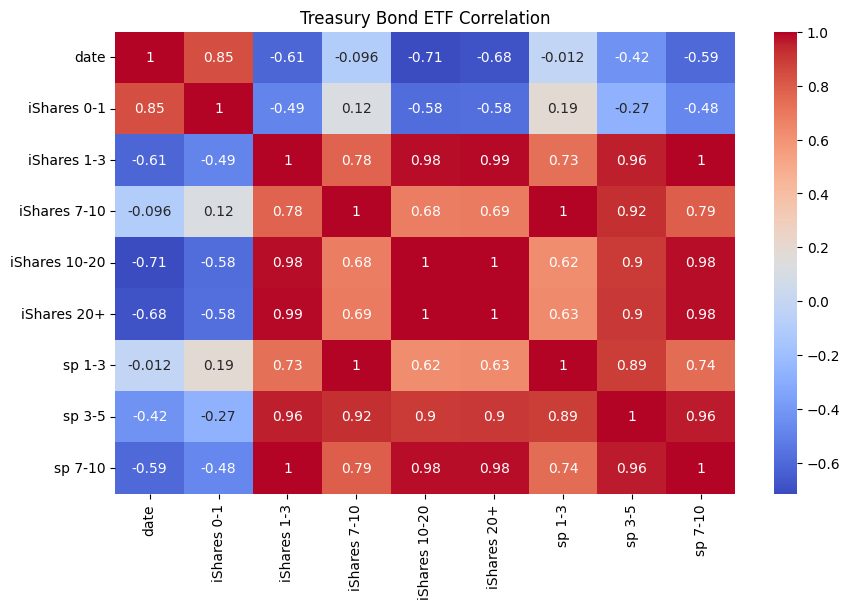

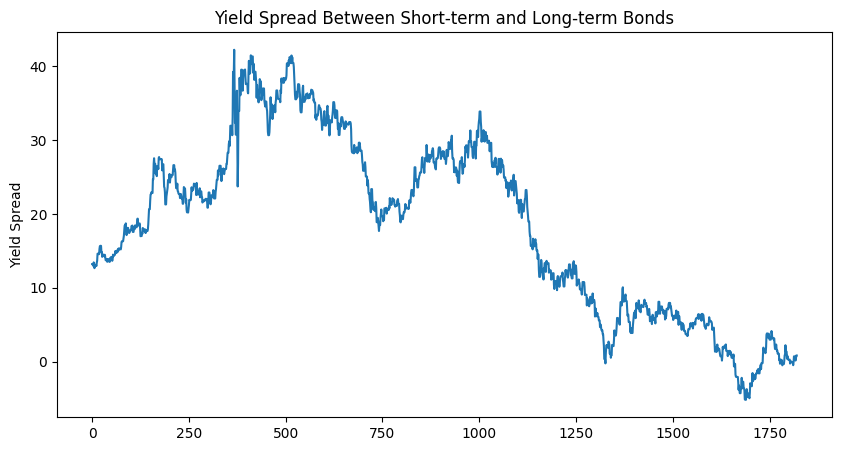

In [4]:
from sklearn.decomposition import PCA

df_tres = treasury_prices_1.copy()

plt.figure(figsize=(10, 6))
sns.heatmap(df_tres.corr(), annot=True, cmap="coolwarm")
plt.title("Treasury Bond ETF Correlation")
plt.show()

# Yield Curve Analysis: Compare short-term vs. long-term bonds
df_tres["Yield Spread (20+ - 1-3)"] = df_tres["iShares 20+"] - df_tres["iShares 1-3"]
plt.figure(figsize=(10, 5))
plt.plot(df_tres.index, df_tres["Yield Spread (20+ - 1-3)"])
plt.title("Yield Spread Between Short-term and Long-term Bonds")
plt.ylabel("Yield Spread")
plt.show()

In [5]:

# Load the data from the manual
def RMBs_Multiplier(df_SP_Treasury_bond_index, df_iShare_MBS_ETF, start_date = '2022-03-31', end_date = '2023-03-31'):
    """
    Calculate the multiplier for the MBS assets based on the change in the S&P U.S. Treasury Bond Index and iShares MBS ETF.

    Parameters:
    df_SP_Treasury_bond_index (pd.DataFrame): DataFrame containing the S&P U.S. Treasury Bond Index data.
    df_iShare_MBS_ETF (pd.DataFrame): DataFrame containing the iShares MBS ETF data.
    start_date (str): Start date for the calculation (default is '2022-03-31').

    Returns:
    float: The multiplier for the MBS assets based on the change in the S&P U.S. Treasury Bond Index and iShares MBS ETF.
    
    """

    upper_treasury = df_SP_Treasury_bond_index.loc[end_date, 'S&P U.S. Treasury Bond Index']
    lower_treasury = df_SP_Treasury_bond_index.loc[start_date, 'S&P U.S. Treasury Bond Index']
    
    upper_MBS = df_iShare_MBS_ETF.loc[end_date, 'Adj Close']
    lower_MBS = df_iShare_MBS_ETF.loc[start_date, 'Adj Close']
    
    MBS_change = (upper_MBS / lower_MBS) - 1
    treasury_change = (upper_treasury / lower_treasury) - 1
    multiplier = MBS_change / treasury_change
    
    return multiplier

def report_losses(df_RMBS_Final, df_loans_first_lien_domestic, df_treasury_and_others, df_other_loan, treasury_prices, RMBS_multiplier, df_asset, start_date = '2022-03-31', end_date = '2023-03-31'):      
    """
    Calculate the losses for each asset type based on the change in the market indices.

    Parameters:
    df_RMBS_Final (pd.DataFrame): DataFrame containing the RMBS assets data.
    df_loans_first_lien_domestic (pd.DataFrame): DataFrame containing the loans data.
    df_treasury_and_others (pd.DataFrame): DataFrame containing the treasury and other assets data.
    df_other_loan (pd.DataFrame): DataFrame containing the other loan assets data.
    treasury_prices (pd.DataFrame): DataFrame containing the treasury prices data.
    RMBS_multiplier (float): The multiplier for the MBS assets based on the change in the S&P U.S. Treasury Bond Index and iShares MBS ETF.
    df_asset (pd.DataFrame): DataFrame containing the total assets data.
    start_date (str): Start date for the calculation (default is '2022-03-31').
    end_date (str): End date for the calculation (default is '2023-03-31').

    Returns:
    pd.DataFrame: DataFrame containing the losses and assets for each bank.
    """  
    # Calculate the price change for each treasury bond
    price_change = {
        '<1y': -0.02,
        '1y-3y': -0.06,
        '3y-5y': -0.10,
        '7y-10y': -0.20,
        '>20y': -0.30
    }

    # Define the mapping of buckets to be used for aggregation
    bucket_mapping = {
        '<3m': '<1y',
        '3m-1y': '<1y',
        '1y-3y': '1y-3y',
        '3y-5y': '3y-5y',
        '5y-15y': '7y-10y',  # Assuming '5y-15y' should be mapped to '7y-10y' based on provided price_change calculation
        '>15y': '>20y',
    }
      
    # Aggregate the assets for each bank
    aggregated_assets = {}
    for name, df in zip(['RMBS', 'Loans', 'Treasury', 'OtherLoan'], 
                        [df_RMBS_Final, df_loans_first_lien_domestic, df_treasury_and_others, df_other_loan]):
        # Ensure columns for aggregation are present
        columns_to_aggregate = [col for col in list(bucket_mapping.keys()) if col in df.columns]
        aggregated_assets[name] = df.groupby(['bank_name', 'Bank_ID'])[columns_to_aggregate].sum().reset_index()
    
    # Initialize DataFrame to store results
    bank_losses_assets = pd.DataFrame(columns=[
        'bank_name', 'bank_ID', 'RMBs_loss', 'treasury_loss', 'loans_loss', 'other_loan_loss', 
        'total_loss', 'Share RMBs', 'Share Treasury and Other', 
        'Share Residential Mortgage', 'Share Other Loan', 'RMBs_asset', 'treasury_asset', 
        'residential_mortgage_asset', 'other_loan_asset', 'core_asset', 'gross_asset', 'loss/core_asset', 'loss/gross_asset',
    ])
    
    # Iterate over each bank to calculate losses and assets
    for _, df_row in df_asset.iterrows():
        bank = df_row['bank_name']
        bank_id = df_row['Bank_ID']
        bank_total_asset = df_row['gross_asset']
        
        #Initialize variables for loss and asset calculations
        rmbs_loss = loans_loss = treasury_loss = other_loan_loss = total_loss = 0
        rmbs_asset = treasury_asset = loan_asset = other_loan_asset = core_asset = 0
        
        #Calculating losses for RMBs
        if 'RMBS' in aggregated_assets and not aggregated_assets['RMBS'].empty:
            rmbs_row = aggregated_assets['RMBS'][(aggregated_assets['RMBS']['bank_name'] == bank) & (aggregated_assets['RMBS']['Bank_ID'] == bank_id)]
            for bucket, treasury_bucket in bucket_mapping.items():
                if bucket in rmbs_row.columns:
                    asset_amount = rmbs_row.iloc[0][bucket] if not rmbs_row.empty else 0
                    rmbs_loss += (asset_amount * RMBS_multiplier * price_change[treasury_bucket])
                    rmbs_asset += asset_amount
                    
        #Calculating losses for loans
        loans_row = aggregated_assets['Loans'][(aggregated_assets['Loans']['bank_name'] == bank) & (aggregated_assets['Loans']['Bank_ID'] == bank_id)]
        if not loans_row.empty:
            for bucket, treasury_bucket in bucket_mapping.items():
                if bucket in loans_row.columns:
                    asset_amount = loans_row.iloc[0][bucket]
                    loans_loss += (asset_amount * RMBS_multiplier * price_change[treasury_bucket])
                    loan_asset += asset_amount

        #Calculating Treasuries
        treasury_row = aggregated_assets['Treasury'][(aggregated_assets['Treasury']['bank_name'] == bank) & (aggregated_assets['Treasury']['Bank_ID'] == bank_id)]
        if not treasury_row.empty:
            for bucket, treasury_bucket in bucket_mapping.items():
                if bucket in treasury_row.columns:
                    asset_amount = treasury_row.iloc[0][bucket]
                    treasury_loss += (asset_amount * price_change[treasury_bucket])
                    treasury_asset += asset_amount

        #Other loans
        other_loan_row = aggregated_assets['OtherLoan'][(aggregated_assets['OtherLoan']['bank_name'] == bank) & (aggregated_assets['OtherLoan']['Bank_ID'] == bank_id)]
        if not other_loan_row.empty:
            for bucket, treasury_bucket in bucket_mapping.items():
                if bucket in other_loan_row.columns:
                    asset_amount = other_loan_row.iloc[0][bucket]
                    other_loan_loss += (asset_amount * price_change[treasury_bucket])
                    other_loan_asset += asset_amount

        # Calculate total loss and core asset      
        total_loss = rmbs_loss + treasury_loss + loans_loss + other_loan_loss
        core_asset = rmbs_asset + treasury_asset + loan_asset + other_loan_asset

        # Append the results to the DataFrame
        bank_losses_assets.loc[len(bank_losses_assets)] = {
            'bank_name': bank,
            'bank_ID': bank_id,
            'RMBs_loss': rmbs_loss,
            'treasury_loss': treasury_loss,
            'loans_loss': loans_loss,
            'other_loan_loss': other_loan_loss,
            'total_loss': total_loss,
            'Share RMBs': rmbs_loss / total_loss if total_loss else 0,
            'Share Treasury and Other': treasury_loss / total_loss if total_loss else 0,
            'Share Residential Mortgage': loans_loss / total_loss if total_loss else 0,
            'Share Other Loan': other_loan_loss / total_loss if total_loss else 0,
            'RMBs_asset': rmbs_asset,
            'treasury_asset': treasury_asset,
            'residential_mortgage_asset': loan_asset,
            'other_loan_asset': other_loan_asset,
            'core_asset': core_asset,
            'gross_asset': bank_total_asset,
            'loss/core_asset': -(total_loss / core_asset) if core_asset else 0,
            'loss/gross_asset': -(total_loss / bank_total_asset) if bank_total_asset else 0,
        }

    return bank_losses_assets

def calculate_uninsured_deposit_mm_asset(uninsured_deposit, bank_losses_assets):
    """
    Calculate the uninsured deposit/MM asset ratio for each bank.

    Parameters:
    uninsured_deposit (pd.DataFrame): DataFrame containing the uninsured deposit data.
    bank_losses_assets (pd.DataFrame): DataFrame containing the losses and assets for each bank.

    Returns:
    pd.DataFrame: DataFrame containing the uninsured deposit/MM asset ratio for each bank.
    """
    
    # Initialize an empty list to store the results
    results = []
    
    # Adjust the uninsured_deposit DataFrame to use both 'bank_name' and 'Bank_ID' as a multi-index for quick lookup
    uninsured_lookup = uninsured_deposit.set_index(['bank_name', 'bank_ID'])['uninsured_deposit'].to_dict()
    
    # Iterate over each row in bank_losses DataFrame
    for _, bank_loss_row in bank_losses_assets.iterrows():
        bank_name = bank_loss_row['bank_name']
        bank_id = bank_loss_row['bank_ID']
        
        # Adjust the lookup to include 'Bank_ID'
        uninsured_deposit_value = uninsured_lookup.get((bank_name, bank_id), 0)
        
        # Calculate 'MM Asset' as (as defined in the paper)
        mm_asset = bank_loss_row['total_loss'] + bank_loss_row['gross_asset']
        
        # Calculate Uninsured Deposit/MM Asset ratio 
        if mm_asset > 0:
            uninsured_deposit_mm_asset_ratio = uninsured_deposit_value / mm_asset
        
        # Append to final dataframe
        results.append({
            'bank_name': bank_name,
            'bank_ID': bank_id, 
            'total_loss': bank_loss_row['total_loss'], 
            'total_asset': bank_loss_row['gross_asset'],
            'mm_asset': mm_asset,
            'uninsured_deposit': uninsured_deposit_value, 
            'Uninsured_Deposit_MM_Asset': uninsured_deposit_mm_asset_ratio
        })

    # Convert results list to DataFrame and sort by 'Bank_ID'
    uninsured_deposit_mm_asset = pd.DataFrame(results).sort_values(by=['bank_name', 'bank_ID'])
    
    return uninsured_deposit_mm_asset

def insured_deposit_coverage_ratio(insured_deposit, uninsured_deposit, bank_losses):
    """
    Calculate the insured deposit coverage ratio for each bank.

    Parameters:
    insured_deposit (pd.DataFrame): DataFrame containing the insured deposit data.
    uninsured_deposit (pd.DataFrame): DataFrame containing the uninsured deposit data.
    bank_losses (pd.DataFrame): DataFrame containing the losses and assets for each bank.

    Returns:
    pd.DataFrame: DataFrame containing the insured deposit coverage ratio for each bank.
    """
    # Initialize an empty list to store the results
    results = []
    
    # Create dictionaries from insured and uninsured deposits for quick lookup
    insured_lookup = insured_deposit.set_index(['bank_name', 'bank_ID'])['insured_deposit'].to_dict()
    uninsured_lookup = uninsured_deposit.set_index(['bank_name', 'bank_ID'])['uninsured_deposit'].to_dict()
    
    # Iterate over each row in bank_losses DataFrame
    for _, bank_loss_row in bank_losses.iterrows():
        bank_name = bank_loss_row['bank_name']
        bank_id = bank_loss_row['bank_ID']
        
        # Retrieve insured and uninsured deposit values
        insured_deposit_value = insured_lookup.get((bank_name, bank_id), 0)
        uninsured_deposit_value = uninsured_lookup.get((bank_name, bank_id), 0)
        
        # Calculate mark-to-market asset value 
        mark_to_market_asset_value = bank_loss_row['total_loss'] + bank_loss_row['gross_asset']
        
        # Calculate the insured deposit coverage ratio
        if insured_deposit_value > 0:  # Prevent division by zero
            coverage_ratio = (mark_to_market_asset_value - uninsured_deposit_value - insured_deposit_value) / insured_deposit_value
        
        # Append the result
        results.append({
            'bank_name': bank_name,
            'bank_ID': bank_id,
            'mm_asset': mark_to_market_asset_value,
            'insured_deposit': insured_deposit_value,
            'uninsured_deposit': uninsured_deposit_value,
            'insured_deposit_coverage_ratio': coverage_ratio
        })
    
    # Convert results list to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

def final_statistic_table(bank_losses_assets, uninsured_deposit_mm_asset, insured_deposit_coverage, index_name = 'All Banks'):
    """
    Calculate the final statistics table for the banks.

    Parameters:
    bank_losses_assets (pd.DataFrame): DataFrame containing the losses and assets for each bank.
    uninsured_deposit_mm_asset (pd.DataFrame): DataFrame containing the uninsured deposit/MM asset ratio for each bank.
    insured_deposit_coverage (pd.DataFrame): DataFrame containing the insured deposit coverage ratio for each bank.
    index_name (str): Name of the index (default is 'All Banks').

    Returns:
    pd.DataFrame: DataFrame containing the final statistics table.
    """
    
    bank_count = len(bank_losses_assets.index)

    final_stats = pd.DataFrame({
        'Aggregate Loss': [f"{-round(bank_losses_assets['total_loss'].sum() / 1e9, 1)}T"],  # Convert to trillions
        'Bank Level Loss': [f"{-round(bank_losses_assets['total_loss'].median() / 1e3, 1)}M"],  # Convert to millions
        'Bank Level Loss Std': [f"{round(bank_losses_assets['total_loss'].std() / 1e6, 2)}B"],  # Std deviation for Bank Level Loss
        'Share RMBS': [round(bank_losses_assets['Share RMBs'].median() * 100, 1)],  # Median percentage
        'Share RMBS Std': [round(bank_losses_assets['Share RMBs'].std() * 100, 1)],  # Std deviation for Share RMBS
        'Share Treasury and Other': [round(bank_losses_assets['Share Treasury and Other'].median() * 100, 1)],  # Median percentage
        'Share Treasury and Other Std': [round(bank_losses_assets['Share Treasury and Other'].std() * 100, 1)],  # Std deviation
        'Share Residential Mortgage': [round(bank_losses_assets['Share Residential Mortgage'].median() * 100, 1)],  # Median percentage
        'Share Residential Mortgage Std': [round(bank_losses_assets['Share Residential Mortgage'].std() * 100, 1)],  # Std deviation
        'Share Other Loan': [round(bank_losses_assets['Share Other Loan'].median() * 100, 1)],  # Median percentage
        'Share Other Loan Std': [round(bank_losses_assets['Share Other Loan'].std() * 100, 1)],  # Std deviation
        'Loss/Asset': [round(bank_losses_assets['loss/gross_asset'].median() * 100, 1)],  # Median percentage
        'Loss/Asset Std': [round(bank_losses_assets['loss/gross_asset'].std() * 100, 1)],  # Std deviation
        'Uninsured Deposit/MM Asset': [round(uninsured_deposit_mm_asset['Uninsured_Deposit_MM_Asset'].median() * 100, 1)],  # Median percentage
        'Uninsured Deposit/MM Asset Std': [round(uninsured_deposit_mm_asset['Uninsured_Deposit_MM_Asset'].std() * 100, 1)],  # Std deviation
        'Insured Deposit Coverage Ratio': [round(insured_deposit_coverage['insured_deposit_coverage_ratio'].median() * 100, 1)],  # Median percentage
        'Insured Deposit Coverage Ratio Std': [round(insured_deposit_coverage['insured_deposit_coverage_ratio'].std() * 100, 1)],  # Std deviation
        'Number of Banks': [len(bank_losses_assets.index.unique())]  # Count of unique banks
    })

    # Rename index to 'All Banks'
    final_stats.index = [index_name]

    final_stats = final_stats.T # Transpose the DataFrame
    
    return final_stats

def GSIB_bank_id():
    """
    Returns a list of GSIB bank IDs.
    """
    #GSIB = [35301,93619,229913,398668,413208,451965,476810,480228,488318,
     #497404,541101,651448,688079,722777,812164,852218,934329,1225761,
     #1443266,1456501,2182786,2362458,2489805,2531991,3066025]
    GSIB = [852218, 480228, 476810, 413208, #JP Morgan, Bank of America, Citigroup, HSBC
      2980209, 2182786, 541101, 655839, 1015560, 229913,#Barclays, Goldman Sachs, BNY Mellon, CCB COMMUNITY BANK, ICBC, Mizuho
       1456501, 722777, 35301, 925411, 497404, 3212149, #Morgan Stanley, Santander, State Street, Sumitomo Mitsui, TD Bank, UBS
      451965] #wells fargo
    return GSIB

def large_ex_GSIB_bank_id(large):
    """
    Returns a list of large non-GSIB bank IDs.
    """
    bank_id_large_ex_GSIB = []
    for bank_id in large['Bank_ID']:
       bank_id_large_ex_GSIB.append(bank_id)
    return bank_id_large_ex_GSIB

def small_bank_id(small):
    """
    Returns a list of small bank IDs.
    """
    bank_id_small = []
    for bank_id in small['Bank_ID']:
       bank_id_small.append(bank_id)
    return bank_id_small

if __name__ == '__main__':

    ##Clean the dataframes for table 1##################################################################################################################################### 
    treasury_prices = Clean_data.clean_treasury_prices(treasury_prices, start_date = '2022-03-31', end_date = '2023-03-31')
    df_SP_Treasury_bond_index = Clean_data.clean_sp_treasury_bond_index(df_SP_Treasury_bond_index, start_date = '2022-03-31', end_date = '2023-03-31')
    df_iShare_MBS_ETF = Clean_data.clean_iShare_MBS_ETF(df_iShare_MBS_ETF, start_date = '2022-03-31', end_date = '2023-03-31')
    RMBS_multiplier = RMBs_Multiplier(df_SP_Treasury_bond_index, df_iShare_MBS_ETF, start_date = '2022-03-31', end_date = '2023-03-31') #MBS multiplier

    ##Prepare the dataframes for table 2 (with most up-to-date market indices data)##################################################################################################################################### 
    treasury_prices_updated = Clean_data.clean_treasury_prices(treasury_prices_1, start_date = '2022-03-31', end_date = '2023-12-31')
    df_SP_Treasury_bond_index_updated = Clean_data.clean_sp_treasury_bond_index(df_SP_Treasury_bond_index_1, start_date = '2022-03-31', end_date = '2023-12-31')
    df_iShare_MBS_ETF_updated = Clean_data.clean_iShare_MBS_ETF(df_iShare_MBS_ETF_1, start_date = '2022-03-31', end_date = '2023-12-31')
    RMBS_multiplier_updated = RMBs_Multiplier(df_SP_Treasury_bond_index_updated, df_iShare_MBS_ETF_updated, start_date = '2022-03-31', end_date = '2023-12-31') #MBS multiplier
    
    ##Get the required dataframes##################################################################################################################################### 
    df_RMBS_Final = Clean_data.get_RMBs(rcfd_series_1, rcon_series_1)
    df_loans_first_lien_domestic = Clean_data.get_loans(rcon_series_1)
    df_treasury_and_others = Clean_data.get_treasuries(rcfd_series_2, rcon_series_2)
    df_other_loan = Clean_data.get_other_loan(rcon_series_2, rcfd_series_1)
    df_asset = Clean_data.get_total_asset(rcfd_series_2, rcon_series_2)
    uninsured_deposit = Clean_data.get_uninsured_deposits(rcon_series_1)
    insured_deposits = Clean_data.get_insured_deposits(rcon_series_1)

    ##Sort the dataframes#####################################################################################################################################
    df_asset = df_asset #total assets all banks
    #GSIB Banks
    GSIB = GSIB_bank_id() #list of GSIB bank IDs
    df_asset_GSIB = df_asset[df_asset['Bank_ID'].isin(GSIB)] #total assets all GSIB banks
    #Large non-GSIB Banks
    df_asset_large_ex_GSIB = df_asset[(~df_asset['Bank_ID'].isin(GSIB)) & (df_asset['gross_asset']>1384000)] #total assets all large non-GSIB banks
    large_ex_GSIB = large_ex_GSIB_bank_id(df_asset_large_ex_GSIB) #list of large non-GSIB bank IDs
    #Small Banks
    df_asset_small = df_asset[(~df_asset['Bank_ID'].isin(GSIB)) & (df_asset['gross_asset']<=1384000)] #total asset all small banks 
    small = small_bank_id(df_asset_small) #list of small bank IDs

    ##Prepare each asset type###################################################################################################################################
    #RMBS
    df_RMBS_Final = df_RMBS_Final #RMBS for all banks 
    df_RMBS_GSIB = df_RMBS_Final[df_RMBS_Final['Bank_ID'].isin(GSIB)] #RMBS for GSIB banks
    df_RMBS_large_ex_GSIB = df_RMBS_Final[df_RMBS_Final['Bank_ID'].isin(large_ex_GSIB)] #RMBS for large non-GSIB banks
    df_RMBS_small = df_RMBS_Final[df_RMBS_Final['Bank_ID'].isin(small)] #RMBS for small banks

    #Loans First Lien Domestic

    df_loans_first_lien_domestic = df_loans_first_lien_domestic # loans first lien domestic for all banks
    df_loans_first_lien_domestic_GSIB = df_loans_first_lien_domestic[df_loans_first_lien_domestic['Bank_ID'].isin(GSIB)] # loans first lien domestic for all GSIB banks
    df_loans_first_lien_domestic_large_ex_GSIB = df_loans_first_lien_domestic[df_loans_first_lien_domestic['Bank_ID'].isin(large_ex_GSIB)] # loans first lien domestic for all large non-GSIB banks
    df_loans_first_lien_domestic_small = df_loans_first_lien_domestic[df_loans_first_lien_domestic['Bank_ID'].isin(small)]

    #Treasury and Others

    df_treasury_and_others = df_treasury_and_others #treasury and others all banks 
    df_treasury_and_others_GSIB = df_treasury_and_others[df_treasury_and_others['Bank_ID'].isin(GSIB)] #treasury and others GSIB banks
    df_treasury_and_others_large_ex_GSIB = df_treasury_and_others[df_treasury_and_others['Bank_ID'].isin(large_ex_GSIB)] #treasury and others large non-GSIB baanks 
    df_treasury_and_others_small = df_treasury_and_others[df_treasury_and_others['Bank_ID'].isin(small)] #treasury and others small banks 
    
    #Other Loan 

    df_other_loan = df_other_loan #other loans for all banks 
    df_other_loan_GSIB = df_other_loan[df_other_loan['Bank_ID'].isin(GSIB)] #other loans for all GSIB banks 
    df_other_loan_large_ex_GSIB = df_other_loan[df_other_loan['Bank_ID'].isin(large_ex_GSIB)] #other loans for all large non-GSIB banks
    df_other_loan_small = df_other_loan[df_other_loan['Bank_ID'].isin(small)] #other oans for all small banks 

    #uninsured deposits
    uninsured_deposit = uninsured_deposit #uninsured deposits for all banks
    uninsured_deposit_GSIB = uninsured_deposit[uninsured_deposit['bank_ID'].isin(GSIB)] #uninsured deposits for GSIB banks
    uninsured_deposit_large_ex_GSIB = uninsured_deposit[uninsured_deposit['bank_ID'].isin(large_ex_GSIB)] #uninsured deposits for large non-GSIB banks
    uninsured_deposit_small = uninsured_deposit[uninsured_deposit['bank_ID'].isin(small)] #uninsured deposits for small banks

    #insured deposits
    insured_deposits = insured_deposits #insured deposits for all banks
    insured_deposits_GSIB = insured_deposits[insured_deposits['bank_ID'].isin(GSIB)] #insured deposits for GSIB banks
    insured_deposits_large_ex_GSIB = insured_deposits[insured_deposits['bank_ID'].isin(large_ex_GSIB)] #insured deposits for large non-GSIB banks
    insured_deposits_small = insured_deposits[insured_deposits['bank_ID'].isin(small)] #insured deposits for small banks

    """
    The following code runs the statistics for table 1 (as in the paper)
    
    """

    ##Calculations for all banks##################################################################################################################################### 
    # Calculate the losses 
    bank_losses_assets = report_losses(df_RMBS_Final, df_loans_first_lien_domestic, df_treasury_and_others, df_other_loan, treasury_prices, RMBS_multiplier, df_asset)
    
    # Calculate the uninsured deposit/MM asset ratio
    uninsured_deposit_mm_asset = calculate_uninsured_deposit_mm_asset(uninsured_deposit, bank_losses_assets)

    # Calculate the insured deposit coverage ratio
    insured_deposit_coverage = insured_deposit_coverage_ratio(insured_deposits, uninsured_deposit, bank_losses_assets)
    
    # Calculate the final statistics table
    final_stats = final_statistic_table(bank_losses_assets, uninsured_deposit_mm_asset, insured_deposit_coverage)
    
    ##################################################################################################################################################################

    ##Calculations for all GSIB banks################################################################################################################################
    # Calculate the losses 
    bank_losses_assets_GSIB = report_losses(df_RMBS_GSIB, df_loans_first_lien_domestic_GSIB, df_treasury_and_others_GSIB, df_other_loan_GSIB, treasury_prices, RMBS_multiplier, df_asset_GSIB)
    
    # Calculate the uninsured deposit/MM asset ratio
    uninsured_deposit_mm_asset_GSIB = calculate_uninsured_deposit_mm_asset(uninsured_deposit_GSIB, bank_losses_assets_GSIB)

    # Calculate the insured deposit coverage ratio
    insured_deposit_coverage_GSIB = insured_deposit_coverage_ratio(insured_deposits_GSIB, uninsured_deposit_GSIB, bank_losses_assets_GSIB)
    
    # Calculate the final statistics table
    final_stats_GSIB = final_statistic_table(bank_losses_assets_GSIB, uninsured_deposit_mm_asset_GSIB, insured_deposit_coverage_GSIB, index_name = 'GSIB Banks')
    ##################################################################################################################################################################

    ##Calculations for all Large non-GSIB banks################################################################################################################################
    # Calculate the losses 
    bank_losses_assets_large_ex_GSIB = report_losses(df_RMBS_large_ex_GSIB, df_loans_first_lien_domestic_large_ex_GSIB, df_treasury_and_others_large_ex_GSIB, df_other_loan_large_ex_GSIB, treasury_prices, RMBS_multiplier, df_asset_large_ex_GSIB)
    
    # Calculate the uninsured deposit/MM asset ratio
    uninsured_deposit_mm_asset_large_ex_GSIB = calculate_uninsured_deposit_mm_asset(uninsured_deposit_large_ex_GSIB, bank_losses_assets_large_ex_GSIB)

    # Calculate the insured deposit coverage ratio
    insured_deposit_coverage_large_ex_GSIB = insured_deposit_coverage_ratio(insured_deposits_large_ex_GSIB, uninsured_deposit_large_ex_GSIB, bank_losses_assets_large_ex_GSIB)
    
    # Calculate the final statistics table
    final_stats_large_ex_GSIB = final_statistic_table(bank_losses_assets_large_ex_GSIB, uninsured_deposit_mm_asset_large_ex_GSIB, insured_deposit_coverage_large_ex_GSIB, index_name = 'Large Ex GSIB Banks')
    ##################################################################################################################################################################

    ##Calculations for small banks################################################################################################################################
    # Calculate the losses 
    bank_losses_assets_small = report_losses(df_RMBS_small, df_loans_first_lien_domestic_small, df_treasury_and_others_small, df_other_loan_small, treasury_prices, RMBS_multiplier, df_asset_small)
    
    # Calculate the uninsured deposit/MM asset ratio
    uninsured_deposit_mm_asset_small = calculate_uninsured_deposit_mm_asset(uninsured_deposit_small, bank_losses_assets_small)

    # Calculate the insured deposit coverage ratio
    insured_deposit_coverage_small = insured_deposit_coverage_ratio(insured_deposits_small, uninsured_deposit_small, bank_losses_assets_small)
    
    # Calculate the final statistics table
    final_stats_small = final_statistic_table(bank_losses_assets_small, uninsured_deposit_mm_asset_small, insured_deposit_coverage_small, index_name = 'Small Banks')
    ##################################################################################################################################################################

    table_1 = pd.concat([final_stats, final_stats_small, final_stats_large_ex_GSIB, final_stats_GSIB], axis=1)



In [6]:
table_1


,All Banks,Small Banks,Large Ex GSIB Banks,GSIB Banks
Aggregate Loss,2.2T,0.2T,1.1T,1.0T
Bank Level Loss,33.3M,25.6M,347.6M,10397.4M
Bank Level Loss Std,6.99B,0.04B,5.29B,99.7B
Share RMBS,6.5,5.6,10.8,17.9
Share RMBS Std,14.5,14.2,15.3,22.7
Share Treasury and Other,17.8,19.3,12.3,15.8
Share Treasury and Other Std,20.0,20.6,15.0,16.1
Share Residential Mortgage,17.6,17.5,18.0,21.9
Share Residential Mortgage Std,19.8,20.0,18.7,16.8
Share Other Loan,41.1,40.0,46.6,23.5


In [7]:
import unittest
import pandas as pd
import re


"""
This script is designed to verify that key values in a DataFrame called table_1 closely match expected reference values. 
It begins by defining helper functions: one (parse_value) converts formatted numeric strings like "2.2T" or "347.6M" into their corresponding float values 
by interpreting suffixes (T for trillions, B for billions, and M for millions) and removing extraneous characters, while the other (approximate_equal) checks 
if two numbers are within a specified tolerance. The main component is a unittest TestCase class that takes table_1 
and a dictionary of reference values as parameters and then runs tests on specific rows—such as "Aggregate Loss", "Number of Banks", 
and "Share RMBS"—to ensure the actual values fall within acceptable tolerances of the expected ones. A helper function 
builds a test suite from these tests, and the main block demonstrates how to execute the tests, 
thereby ensuring that the computed values in table_1 are sufficiently close to the original reference data without hard-coding the values globally.
"""

def parse_value(value_str):
    """
    Convert a string like '2.2T', '347.6M', '99.7B', or '6.5' into a float.
    Handles negatives and removes extra characters (like commas or parentheses).
    """
    # Clean up the string
    value_str = value_str.strip().replace(',', '')
    value_str = value_str.strip('()')
    
    sign = 1
    if value_str.startswith('-'):
        sign = -1
        value_str = value_str[1:]
    
    # Extract numeric part and unit
    match = re.match(r'([\d\.]+)([TBM]*)', value_str)
    if not match:
        try:
            return sign * float(value_str)
        except ValueError:
            raise ValueError(f"Cannot parse value string: {value_str}")
    
    num_part = float(match.group(1))
    unit = match.group(2)
    
    multiplier = 1.0
    if unit == 'T':
        multiplier = 1e12
    elif unit == 'B':
        multiplier = 1e9
    elif unit == 'M':
        multiplier = 1e6
        
    return sign * num_part * multiplier

def approximate_equal(actual, expected, tolerance):
    """Return True if actual is within ±tolerance of expected."""
    return abs(actual - expected) <= tolerance

class TestTable1Proximity(unittest.TestCase):
    """
    A TestCase class that compares key values in table_1
    against expected (reference) values. Both table_1 and the
    reference values are provided as parameters.
    """
    def __init__(self, methodName='runTest', table_1=None, reference=None):
        super(TestTable1Proximity, self).__init__(methodName)
        self.table_1 = table_1
        self.reference = reference

    def test_proximity_aggregate_loss(self):
        """
        Check that the 'Aggregate Loss' row in each column is within tolerance
        of the expected reference value.
        """
        row_label = 'Aggregate Loss'
        for col, (expected_val, tolerance) in self.reference[row_label].items():
            with self.subTest(column=col):
                actual_str = str(self.table_1.loc[row_label, col])
                actual_num = parse_value(actual_str)
                condition = approximate_equal(actual_num, expected_val, tolerance)
                self.assertTrue(
                    condition,
                    msg=(f"Aggregate Loss mismatch for column '{col}': "
                         f"got {actual_num}, expected {expected_val} ± {tolerance}")
                )
                if condition:
                    print(f"Passed test to check tolerance of '{row_label}' in column '{col}': "
                          f"got {actual_num}, expected {expected_val} ± {tolerance}")

    def test_number_of_banks(self):
        """
        Check that the 'Number of Banks' row in each column is within tolerance
        of the expected reference value.
        """
        row_label = 'Number of Banks'
        for col, (expected_val, tolerance) in self.reference[row_label].items():
            with self.subTest(column=col):
                actual_str = str(self.table_1.loc[row_label, col])
                try:
                    actual_num = float(actual_str)
                except ValueError:
                    actual_num = parse_value(actual_str)
                condition = approximate_equal(actual_num, expected_val, tolerance)
                self.assertTrue(
                    condition,
                    msg=(f"Number of Banks mismatch for column '{col}': "
                         f"got {actual_num}, expected {expected_val} ± {tolerance}")
                )
                if condition:
                    print(f"Passed test to check tolerance of '{row_label}' in column '{col}': "
                          f"got {actual_num}, expected {expected_val} ± {tolerance}")

    def test_share_rmbs(self):
        """
        Check that the 'Share RMBS' row in each column is within tolerance
        of the expected reference value.
        """
        row_label = 'Share RMBS'
        for col, (expected_val, tolerance) in self.reference[row_label].items():
            with self.subTest(column=col):
                actual_str = str(self.table_1.loc[row_label, col])
                actual_num = parse_value(actual_str)
                condition = approximate_equal(actual_num, expected_val, tolerance)
                self.assertTrue(
                    condition,
                    msg=(f"Share RMBS mismatch for column '{col}': "
                         f"got {actual_num}, expected {expected_val} ± {tolerance}")
                )
                if condition:
                    print(f"Passed test to check tolerance of '{row_label}' in column '{col}': "
                          f"got {actual_num}, expected {expected_val} ± {tolerance}")

def load_tests(table_1, reference):
    """
    Build and return a unittest.TestSuite using the provided table_1 DataFrame and
    reference values.
    
    Args:
        table_1 (pd.DataFrame): The DataFrame to test.
        reference (dict): A dictionary of reference values.
    
    Returns:
        unittest.TestSuite: The test suite.
    """
    suite = unittest.TestSuite()
    # Add each test by specifying the test method name and passing table_1 and reference
    suite.addTest(TestTable1Proximity('test_proximity_aggregate_loss', table_1=table_1, reference=reference))
    suite.addTest(TestTable1Proximity('test_number_of_banks', table_1=table_1, reference=reference))
    suite.addTest(TestTable1Proximity('test_share_rmbs', table_1=table_1, reference=reference))
    return suite

if __name__ == '__main__':
    
    # Define the reference dictionary with expected values and tolerances.
    reference = {
        'Aggregate Loss': {
            'All Banks': (2.2e12, 0.3e12),
            'Small Banks': (0.2e12, 0.1e12),
            'Large Ex GSIB Banks': (1.1e12, 0.2e12),
            'GSIB Banks': (1.0e12, 0.2e12)
        },
        'Number of Banks': {
            'All Banks': (4844, 100),
            'Small Banks': (4095, 100),
            'Large Ex GSIB Banks': (732, 50),
            'GSIB Banks': (17, 5)
        },
        'Share RMBS': {
            'All Banks': (6.5, 2.0),
            'Small Banks': (5.6, 2.0),
            'Large Ex GSIB Banks': (10.8, 3.0),
            'GSIB Banks': (17.9, 3.0)
        },
    }
    
    # Build and run the test suite using the provided table_1 and reference values.
    suite = load_tests(table_1, reference)
    unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 0.003s

OK


Passed test to check tolerance of 'Aggregate Loss' in column 'All Banks': got 2200000000000.0, expected 2200000000000.0 ± 300000000000.0
Passed test to check tolerance of 'Aggregate Loss' in column 'Small Banks': got 200000000000.0, expected 200000000000.0 ± 100000000000.0
Passed test to check tolerance of 'Aggregate Loss' in column 'Large Ex GSIB Banks': got 1100000000000.0, expected 1100000000000.0 ± 200000000000.0
Passed test to check tolerance of 'Aggregate Loss' in column 'GSIB Banks': got 1000000000000.0, expected 1000000000000.0 ± 200000000000.0
Passed test to check tolerance of 'Number of Banks' in column 'All Banks': got 4844.0, expected 4844 ± 100
Passed test to check tolerance of 'Number of Banks' in column 'Small Banks': got 4095.0, expected 4095 ± 100
Passed test to check tolerance of 'Number of Banks' in column 'Large Ex GSIB Banks': got 732.0, expected 732 ± 50
Passed test to check tolerance of 'Number of Banks' in column 'GSIB Banks': got 17.0, expected 17 ± 5
Passed te

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(table_1.shape[1] * 2, table_1.shape[0] * 0.5 + 1))
ax.axis('off')
table = ax.table(cellText=table_1.values,
                 colLabels=table_1.columns,
                 loc='center',
                 cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.tight_layout()
plt.savefig("table_1.png", dpi=300, bbox_inches='tight')
plt.close()